In [1]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.matlib as matlib
from numpy import nan
from numpy.linalg import norm as norm
import os
import time as tmp
import commands

import tsid
import pinocchio as se3


import plot_utils as plut

In [2]:
import gepetto.corbaserver


## Test Task Space Inverse Dynamics

In [3]:
lxp = 0.14                          # foot length in positive x direction
lxn = 0.077                         # foot length in negative x direction
lyp = 0.069                         # foot length in positive y direction
lyn = 0.069                         # foot length in negative y direction
lz = 0.105                          # foot sole height with respect to ankle joint
mu = 0.3                            # friction coefficient
fMin = 5.0                          # minimum normal force
fMax = 1000.0                       # maximum normal force
rf_frame_name = "leg_right_6_link"        # right foot frame name
lf_frame_name = "leg_left_6_link"        # left foot frame name
contactNormal = np.matrix([0., 0., 1.]).T   # direction of the normal to the contact surface

w_com = 1.0                     # weight of center of mass task
w_posture = 1.0                # weight of joint posture task
w_forceRef = 1e-5               # weight of force regularization task

kp_contact = 10.0               # proportional gain of contact constraint
kp_com = 10.0                   # proportional gain of center of mass task
kp_posture = 10.0               # proportional gain of joint posture task

dt = 0.001                      # controller time step
PRINT_N = 500                   # print every PRINT_N time steps
DISPLAY_N = 25                  # update robot configuration in viwewer every DISPLAY_N time steps
N_SIMULATION = 4000             # number of time steps simulated

In [4]:
path = "/opt/openrobots/share"
urdf = path + '/talos_data/urdf/talos_reduced.urdf'
vector = se3.StdVec_StdString()
vector.extend(item for item in path)
robot = tsid.RobotWrapper(urdf, vector, se3.JointModelFreeFlyer(), False)
srdf = path + '/talos_data/srdf/talos.srdf'


In [5]:
# for gepetto viewer
robot_display = se3.RobotWrapper.BuildFromURDF(urdf, [path, ], se3.JointModelFreeFlyer())
l = commands.getstatusoutput("ps aux |grep 'gepetto-gui'|grep -v 'grep'|wc -l")
if int(l[1]) == 0:
    os.system('gepetto-gui &')
tmp.sleep(1)
cl = gepetto.corbaserver.Client()
gui = cl.gui
robot_display.initDisplay(loadModel=True)


In [6]:
#help(se3.loadReferenceConfigurations)
#help(robot.model().referenceConfigurations)

In [7]:
model = robot.model()
se3.loadReferenceConfigurations(model, srdf, False)
q = model.referenceConfigurations['half_sitting']
v = np.matrix(np.zeros(robot.nv)).T

In [8]:
robot_display.displayCollisions(False)
robot_display.displayVisuals(True)
robot_display.display(q)

In [9]:
assert model.existFrame(rf_frame_name)
assert model.existFrame(lf_frame_name)

In [10]:
t = 0.0                         # time
invdyn = tsid.InverseDynamicsFormulationAccForce("tsid", robot, False)
invdyn.computeProblemData(t, q, v)
data = invdyn.data()


In [11]:
# CONTACTS
contact_Point = np.matrix(np.ones((3,4)) * lz)
contact_Point[0, :] = [-lxn, -lxn, lxp, lxp]
contact_Point[1, :] = [-lyn, lyp, -lyn, lyp]

contactRF = tsid.Contact6d("contact_rfoot", robot, rf_frame_name, contact_Point, contactNormal, mu, fMin, fMax)
contactRF.setKp(kp_contact * matlib.ones(6).T)
contactRF.setKd(2.0 * np.sqrt(kp_contact) * matlib.ones(6).T)
H_rf_ref = robot.position(data, model.getJointId(rf_frame_name))
contactRF.setReference(H_rf_ref)
invdyn.addRigidContact(contactRF, w_forceRef)

contactLF =tsid.Contact6d("contact_lfoot", robot, lf_frame_name, contact_Point, contactNormal, mu, fMin, fMax)
contactLF.setKp(kp_contact * matlib.ones(6).T)
contactLF.setKd(2.0 * np.sqrt(kp_contact) * matlib.ones(6).T)
H_lf_ref = robot.position(data, model.getJointId(lf_frame_name))
contactLF.setReference(H_lf_ref)
invdyn.addRigidContact(contactLF, w_forceRef)

True

In [12]:
# COM
comTask = tsid.TaskComEquality("task-com", robot)
comTask.setKp(kp_com * matlib.ones(3).T)
comTask.setKd(2.0 * np.sqrt(kp_com) * matlib.ones(3).T)
invdyn.addMotionTask(comTask, w_com, 1, 0.0)

# POSTURE
postureTask = tsid.TaskJointPosture("task-posture", robot)
postureTask.setKp(kp_posture * matlib.ones(robot.nv-6).T)
kd = 2.0 * np.sqrt(kp_posture) * matlib.ones(robot.nv-6).T
# kd[7:13] = 0.
kd[13:] = 0.
postureTask.setKd(kd)
invdyn.addMotionTask(postureTask, w_posture, 1, 0.0)

data_model = model.createData()
se3.forwardKinematics(model, data_model, q)
se3.centerOfMass(model, data_model, q)

com_ref = data_model.com[0]
trajCom = tsid.TrajectoryEuclidianConstant("traj_com", com_ref)

In [13]:
q_ref = q[7:]
trajPosture = tsid.TrajectoryEuclidianConstant("traj_joint", q_ref)

solver = tsid.SolverHQuadProgFast("qp solver")
solver.resize(invdyn.nVar, invdyn.nEq, invdyn.nIn)

com_pos = matlib.empty((3, N_SIMULATION))*nan
com_vel = matlib.empty((3, N_SIMULATION))*nan
com_acc = matlib.empty((3, N_SIMULATION))*nan

com_pos_ref = matlib.empty((3, N_SIMULATION))*nan
com_vel_ref = matlib.empty((3, N_SIMULATION))*nan
com_acc_ref = matlib.empty((3, N_SIMULATION))*nan
com_acc_des = matlib.empty((3, N_SIMULATION))*nan # acc_des = acc_ref - Kp*pos_err - Kd*vel_err

for i in range(0, N_SIMULATION):
    time_start = tmp.time()
    
    sampleCom = trajCom.computeNext()
    comTask.setReference(sampleCom)
    samplePosture = trajPosture.computeNext()
    postureTask.setReference(samplePosture)

    HQPData = invdyn.computeProblemData(t, q, v)
    # if i == 0: HQPData.print_all()

    sol = solver.solve(HQPData)
    if(sol.status!=0):
        print "QP problem could not be solved! Error code:", sol.status
        break
    
    tau = invdyn.getActuatorForces(sol)
    dv = invdyn.getAccelerations(sol)
    
    com_pos[:,i] = robot.com(invdyn.data())
    com_vel[:,i] = robot.com_vel(invdyn.data())
    com_acc[:,i] = comTask.getAcceleration(dv)
    com_pos_ref[:,i] = sampleCom.pos()
    com_vel_ref[:,i] = sampleCom.vel()
    com_acc_ref[:,i] = sampleCom.acc()
    com_acc_des[:,i] = comTask.getDesiredAcceleration

    if i%PRINT_N == 0:
        print "Time %.3f"%(t)
        if invdyn.checkContact(contactRF.name, sol):
            f = invdyn.getContactForce(contactRF.name, sol)
            print "\tnormal force %s: %.1f"%(contactRF.name.ljust(20,'.'),contactRF.getNormalForce(f))

        if invdyn.checkContact(contactLF.name, sol):
            f = invdyn.getContactForce(contactLF.name, sol)
            print "\tnormal force %s: %.1f"%(contactLF.name.ljust(20,'.'),contactLF.getNormalForce(f))
# 
        print "\ttracking err %s: %.3f"%(comTask.name.ljust(20,'.'),       norm(comTask.position_error, 2))
        print "\t||v||: %.3f\t ||dv||: %.3f"%(norm(v, 2), norm(dv))

    v_mean = v + 0.5*dt*dv
    v += dt*dv
    q = se3.integrate(model, q, dt*v_mean)
    t += dt
    
    if i%DISPLAY_N == 0: robot_display.display(q)

    time_spent = tmp.time() - time_start
    if(time_spent < dt): tmp.sleep(dt-time_spent)

Time 0.000
	normal force contact_rfoot.......: 439.9
	normal force contact_lfoot.......: 451.8
	tracking err task-com............: 0.000
	||v||: 0.000	 ||dv||: 0.630
Time 0.500
	normal force contact_rfoot.......: 441.1
	normal force contact_lfoot.......: 451.9
	tracking err task-com............: 0.025
	||v||: 0.100	 ||dv||: 0.091
Time 1.000
	normal force contact_rfoot.......: 440.8
	normal force contact_lfoot.......: 454.6
	tracking err task-com............: 0.071
	||v||: 0.141	 ||dv||: 0.122
Time 1.500
	normal force contact_rfoot.......: 438.8
	normal force contact_lfoot.......: 459.4
	tracking err task-com............: 0.142
	||v||: 0.213	 ||dv||: 0.180
Time 2.000
	normal force contact_rfoot.......: 437.0
	normal force contact_lfoot.......: 465.8
	tracking err task-com............: 0.252
	||v||: 0.325	 ||dv||: 0.282
Time 2.500
	normal force contact_rfoot.......: 476.9
	normal force contact_lfoot.......: 429.5
	tracking err task-com............: 0.418
	||v||: 0.508	 ||dv||: 0.729
Time

In [14]:
# PLOT STUFF
time = np.arange(0.0, N_SIMULATION*dt, dt)


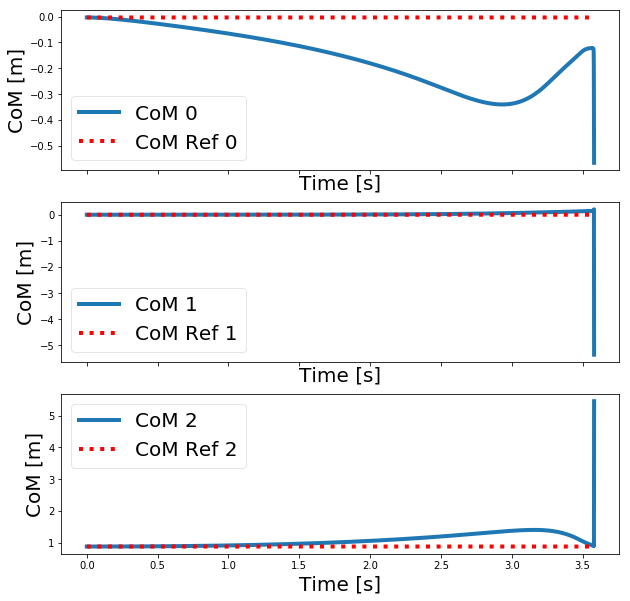

In [15]:
(f, ax) = plut.create_empty_figure(3,1)
for i in range(3):
    ax[i].plot(time, com_pos[i,:].A1, label='CoM '+str(i))
    ax[i].plot(time, com_pos_ref[i,:].A1, 'r:', label='CoM Ref '+str(i))
    ax[i].set_xlabel('Time [s]')
    ax[i].set_ylabel('CoM [m]')
    leg = ax[i].legend()
    leg.get_frame().set_alpha(0.5)

plt.show()

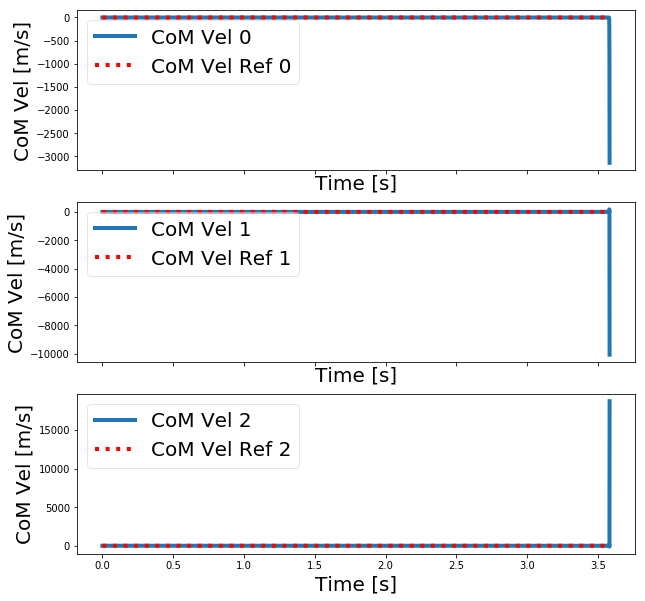

In [16]:
(f, ax) = plut.create_empty_figure(3,1)
for i in range(3):
    ax[i].plot(time, com_vel[i,:].A1, label='CoM Vel '+str(i))
    ax[i].plot(time, com_vel_ref[i,:].A1, 'r:', label='CoM Vel Ref '+str(i))
    ax[i].set_xlabel('Time [s]')
    ax[i].set_ylabel('CoM Vel [m/s]')
    leg = ax[i].legend()
    leg.get_frame().set_alpha(0.5)

plt.show()


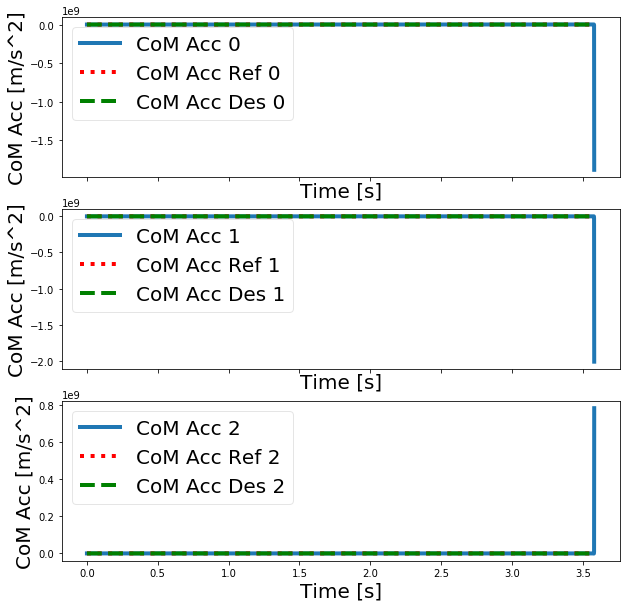

In [17]:

(f, ax) = plut.create_empty_figure(3,1)
for i in range(3):
    ax[i].plot(time, com_acc[i,:].A1, label='CoM Acc '+str(i))
    ax[i].plot(time, com_acc_ref[i,:].A1, 'r:', label='CoM Acc Ref '+str(i))
    ax[i].plot(time, com_acc_des[i,:].A1, 'g--', label='CoM Acc Des '+str(i))
    ax[i].set_xlabel('Time [s]')
    ax[i].set_ylabel('CoM Acc [m/s^2]')
    leg = ax[i].legend()
    leg.get_frame().set_alpha(0.5)
    
plt.show()